# Pre-process WAVE file for ANIMAL-SPOT

### Our backgrounds

In [2]:
import pandas as pd

In [5]:
bg_file = "/run/media/poulpos/PIGS-KU-MA1/bandpassed/BOX1-FARMHH/backgrounds/background~parameters.tsv"

In [8]:
df = pd.read_csv(bg_file, sep="\t")

In [9]:
df.head()

chunks_origin      start        end label  \
0  background~BOX1-FARMHH_20230526_170000~b~1  11.034520  12.165331     b   
1  background~BOX1-FARMHH_20230526_170000~b~2  14.755251  15.940778     b   
2  background~BOX1-FARMHH_20230526_170000~b~3  18.576296  22.698282     b   
3  background~BOX1-FARMHH_20230526_170000~b~4  25.452352  27.823406     b   
4  background~BOX1-FARMHH_20230526_170000~b~5  35.529331  36.568947     b   

   index                          rec_wav                       origin  \
0      1  BOX1-FARMHH_20230526_170000.wav  BOX1-FARMHH_20230526_170000   
1      2  BOX1-FARMHH_20230526_170000.wav  BOX1-FARMHH_20230526_170000   
2      3  BOX1-FARMHH_20230526_170000.wav  BOX1-FARMHH_20230526_170000   
3      4  BOX1-FARMHH_20230526_170000.wav  BOX1-FARMHH_20230526_170000   
4      5  BOX1-FARMHH_20230526_170000.wav  BOX1-FARMHH_20230526_170000   

    rec_box_id      date    time  
0  BOX1-FARMHH  20230526  170000  
1  BOX1-FARMHH  20230526  170000  
2  BOX1-FARMHH  20230526  170000  
3  BOX1-FARMHH  20230526  170000  
4  BOX1-FARMHH  20230526  170000

In [10]:
df["duration"] = df["end"] - df["start"]

<Axes: title={'center': 'duration'}, xlabel='[label]'>

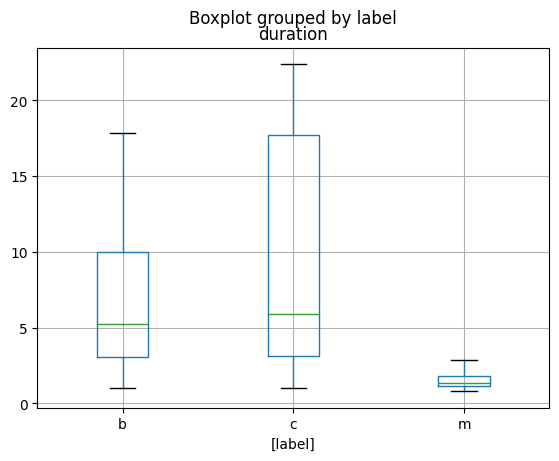

In [27]:
df[["duration", "label"]].boxplot(by="label", showfliers=False)

In [14]:
pd.unique(df["label"])

array(['b', 'c', 'm'], dtype=object)

In [15]:
df.shape

(120, 11)

In [26]:
for label in pd.unique(df["label"]):
    filtered = df[df["label"] == label]
    print(f"label: {label}, {filtered.shape[0]: 5} files, total: {filtered['duration'].sum(): 10}s")
print(50*"-")
print(f"label: *, {df.shape[0]: 5} files, total: {df['duration'].sum(): 10}s")

label: b,    54 files, total:  601.1127640000001s
label: c,    21 files, total:  1197.056384s
label: m,    45 files, total:  72.8917190000001s
--------------------------------------------------
label: *,   120 files, total:  1871.0608670000001s


## Clipping/Naming files

In [6]:
import soundfile as sf
import random
import math
import numpy as np
import glob, os
import pandas as pd

In [11]:
import math
def chop(input_dir, origin, prefix, output_dir, target_duration=0.5, ext=".wav", overlap_enabled=True, compute_rms=False):
    """
    - Pad randomly with silence if the file is shorter than the target
    - If the file is longer: cover the whole file while minimizing overlap
    """
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    input_file = os.path.join(input_dir, origin + ext)
    input_sound = sf.SoundFile(input_file, "r")
    sr = input_sound.samplerate
    target_frames = target_duration * input_sound.samplerate
    write_params = {"subtype": input_sound.subtype,
                    "endian":input_sound.endian,
                    "format":input_sound.format}
    expected_frames = math.floor(target_duration * sr)
    if prefix != "":
        origin = prefix + "_" + origin
    rmss = None
    
    if input_sound.frames < expected_frames:
        data = input_sound.read()
        block = np.zeros(math.floor(target_duration * sr), dtype=data.dtype)
        iframe_start = random.randrange(math.floor(target_duration * sr - data.shape[0]))
        block[iframe_start:iframe_start+input_sound.frames] = data
        cur_origin = f"{origin}_0_{math.floor(input_sound.frames / sr * 1000)}.wav"
        sf.write(os.path.join(output_dir, cur_origin),
                 block, sr, **write_params)
        if compute_rms is True:
            rms = np.sqrt(np.mean(block**2))
            return pd.DataFrame(data={'file': [cur_origin], 'rms': [rms]})
        return
    

    
    n_blocks = math.ceil(input_sound.frames / target_frames)
    n_overlapping_frames = n_blocks * target_frames - input_sound.frames
    if overlap_enabled:
        overlap = math.floor(n_overlapping_frames / (n_blocks - 1))
    else:
        overlap = 0
    iframe_beg_block = 0
    start_ms = 0
    for block in sf.blocks(input_file, blocksize=expected_frames, overlap=overlap):
        if len(block) + 100 < expected_frames:
            print(f"File {origin}, frame starting at {iframe_beg_block}")
            print(f"Block of size {len(block)} instead of {expected_frames}")
            break
        iframe_end_block = iframe_beg_block + len(block)
        end_ms = math.floor(iframe_end_block / sr * 1000)
        cur_origin = f"{origin}_{start_ms}_{end_ms}.wav"
        sf.write(os.path.join(output_dir, cur_origin),
                 block, sr, **write_params)
        if compute_rms is True:
            rms = pd.DataFrame(data={'file': [cur_origin],
                                     'rms': [np.sqrt(np.mean(block**2))]}
                              )
            if rmss is None:
                rmss = rms
            else:
                rmss = pd.concat([rmss, rms], copy=False, ignore_index=True)
        iframe_beg_block = iframe_end_block - overlap
        start_ms = math.floor(iframe_beg_block / sr * 1000)
    
    if compute_rms is True:
        return rmss if rmss is not None else pd.DataFrame(columns=['file', 'rms'])

### Background

In [ ]:
as_bg_path = "/run/media/poulpos/PIGS-KU-BU2/background"

bg_init = os.path.join(as_bg_path)
bg_dst = os.path.join("/run/media/poulpos/PIGS-KU-BU2", "background-cut")

for file in glob.glob("*.wav", root_dir=bg_init):
    origin = file[:-4]
    chop(bg_init, origin, "",
         bg_dst, target_duration=3, overlap_enabled=False)

### Soundwel sounds

In [1]:
src_data_path = "/run/media/poulpos/PIGS-KU-BU1"
as_data_path = "/run/media/poulpos/PIGS-KU-BU2/input"

In [77]:
101%100

1

In [7]:
from datetime import datetime

sw_init = os.path.join(src_data_path, "Soundwel Dataset - Audio and Spectrograms")
sw_csv = "/home/poulpos/pigs-documentary/SoundwelDatasetKey.csv"

flavor = {'HF': {'duration': 430}, 'LF': {'duration': 260}}

for k,v in flavor.items():
    v['path'] = os.path.join(as_data_path, f"{v['duration']}ms", "soundwel")

sw_df = pd.read_csv(sw_csv)
for i, file in enumerate(glob.glob("*.wav", root_dir=sw_init)):
    if i % 100 == 0:
        print(f"{datetime.now()} {i}")
    origin = file[:-4]
    row = sw_df[sw_df['Audio Filename'] == file]
    if len(row) != 1:
        print(f"Issue with {file}")
        print(row)
    ct = row.iloc[0]["Type"]
    if ct in ['HF', 'LF']:
        chop(sw_init, origin, f"target-{ct}" ,
             flavor[ct]['path'], target_duration=flavor[ct]['duration']*.001)
    else:
        for cth in ['HF', 'LF']:
            chop(sw_init, origin, f"target-{ct}" ,
             flavor[cth]['path'], target_duration=flavor[cth]['duration']*.001)

2023-10-16 14:24:50.476162 0
2023-10-16 14:25:20.020183 100
2023-10-16 14:25:46.259615 200
2023-10-16 14:26:10.589796 300
2023-10-16 14:26:29.346210 400
2023-10-16 14:26:47.846275 500
2023-10-16 14:27:05.476131 600
2023-10-16 14:27:24.113062 700
2023-10-16 14:27:41.639479 800
2023-10-16 14:28:02.956211 900
2023-10-16 14:28:23.666312 1000
2023-10-16 14:28:42.916140 1100
2023-10-16 14:29:02.166473 1200
2023-10-16 14:29:20.533237 1300
2023-10-16 14:29:40.702870 1400
2023-10-16 14:29:57.309668 1500
2023-10-16 14:30:15.392794 1600
2023-10-16 14:30:35.373111 1700
2023-10-16 14:31:04.576632 1800
2023-10-16 14:31:35.573064 1900
2023-10-16 14:31:49.112814 2000
2023-10-16 14:32:11.519882 2100
2023-10-16 14:32:34.756151 2200
2023-10-16 14:33:04.629600 2300
2023-10-16 14:33:34.286385 2400
2023-10-16 14:34:04.066255 2500
2023-10-16 14:34:28.036285 2600
2023-10-16 14:34:54.559647 2700
2023-10-16 14:35:22.169672 2800
2023-10-16 14:35:50.499711 2900
2023-10-16 14:36:14.179511 3000
2023-10-16 14:36:34.

### Farm sounds

1. Upload full files + `*.bg.clean.txt`
2. Chop
3. Clean:
     - `~` or `_` -> `-`
     - `noise-` + `noiseType` at the beginning
4. Move to DATA, add ids

#### Without bg dispatch

In [8]:
def dispatch_ignore_bg(input_dir, dst_dir, label_ext=".bg.clean.txt", classname="noise"):
    nchar_ext = len(label_ext)
    if not os.path.isdir(dst_dir):
        os.mkdir(dst_dir)
    for label_file in glob.glob("*.bg.clean.txt", root_dir=input_dir):
        print(f"  label file: {label_file}")
        origin = label_file[:-nchar_ext]
        clean_origin = origin.replace("_", "-")
        labels = pd.read_csv(os.path.join(input_dir, label_file), sep="\t")
        with sf.SoundFile(os.path.join(input_dir, origin + ".wav")) as sound_file:
            for l, row in labels.iterrows():
                end_frame = math.floor(row.end * sound_file.samplerate)
                cur_frame = math.floor(row.start * sound_file.samplerate)
                cur_origin = f"{classname}-{row.label}_{clean_origin}"
                if row.label == 'c':
                    continue
                new_name = "-".join([cur_origin,
                                         str(math.floor(cur_frame/sound_file.samplerate*1000)),
                                         str(math.floor(end_frame/sound_file.samplerate*1000))])
                sound_file.seek(cur_frame)
                data = sound_file.read(frames = end_frame - cur_frame)
                sf.write(os.path.join(dst_dir, new_name + ".wav"), data,
                         sound_file.samplerate, subtype=sound_file.subtype, endian=sound_file.endian, format=sound_file.format)

In [9]:
data_path = os.path.join(src_data_path, "bandpassed")
dst_path = "/run/media/poulpos/PIGS-KU-BU2/farm_noise"
for farm in os.listdir(data_path):
    print(f"Farm {farm}")
    farm_path = os.path.join(data_path, farm)
    if os.path.isdir(farm_path):
        dst_farm = os.path.join(dst_path, farm)
        dispatch_ignore_bg(farm_path, dst_farm)

Farm BOX1-FARMEIK
  label file: BOX1-FARMEIK_20230801_161500.bg.clean.txt
  label file: BOX1-FARMEIK_20230802_000000.bg.clean.txt
  label file: BOX1-FARMEIK_20230803_073000.bg.clean.txt
  label file: BOX1-FARMEIK_20230804_123000.bg.clean.txt
  label file: BOX1-FARMEIK_20230805_200000.bg.clean.txt
  label file: BOX1-FARMEIK_20230806_100000.bg.clean.txt
  label file: BOX1-FARMEIK_20230807_184500.bg.clean.txt
  label file: BOX1-FARMEIK_20230808_084500.bg.clean.txt
Farm BOX1-FARMHE1
  label file: BOX1-FARMHE1_20230808_161500.bg.clean.txt
  label file: BOX1-FARMHE1_20230809_000000.bg.clean.txt
  label file: BOX1-FARMHE1_20230810_073000.bg.clean.txt
  label file: BOX1-FARMHE1_20230811_123000.bg.clean.txt
  label file: BOX1-FARMHE1_20230812_173000.bg.clean.txt
  label file: BOX1-FARMHE1_20230813_200000.bg.clean.txt
  label file: BOX1-FARMHE1_20230814_100000.bg.clean.txt
  label file: BOX1-FARMHE1_20230815_184500.bg.clean.txt
Farm BOX1-FARMHH
  label file: BOX1-FARMHH_20230526_170000.bg.clean.

In [21]:
from datetime import datetime

farm_init = "/run/media/poulpos/PIGS-KU-BU2/farm_noise"
dst_path = "/run/media/poulpos/PIGS-KU-BU2/chopped_farm_noise"

duration = [430, 260]

for farm in os.listdir(farm_init):
    print(f"{datetime.now()} Farm {farm}")
    farm_path = os.path.join(farm_init, farm)
    for dur in duration:
        farm_dst_path = os.path.join(dst_path, f"{dur}ms", farm)
        rmss = pd.DataFrame(columns=["file", "rms", "type"])
        for file in glob.glob("*.wav", root_dir=farm_path): 
            rms = chop(farm_path, file[:-4], "" ,
                 farm_dst_path, target_duration=dur*.001, compute_rms=True)
            rms['type'] = rms['file'].str[6]
            rmss = pd.concat([rmss, rms], ignore_index=True, copy=False)
        rmss.to_csv(os.path.join(farm_dst_path, "rms.csv"), index=False)
        print(f"{datetime.now()} Saved rms: {os.path.join(farm_dst_path, 'rms.csv')}")

2023-10-16 17:33:09.640202 Farm BOX1-FARMEIK
File noise-m_BOX1-FARMEIK-20230808-084500-221382-304330, frame starting at 3639168
Block of size 18827 instead of 18963
2023-10-16 17:35:49.068484 Saved rms: /run/media/poulpos/PIGS-KU-BU2/chopped_farm_noise/430ms/BOX1-FARMEIK/rms.csv
File noise-m_BOX1-FARMEIK-20230806-100000-263633-307403, frame starting at 1918896
Block of size 11360 instead of 11466
File noise-m_BOX1-FARMEIK-20230808-084500-221382-304330, frame starting at 3646808
Block of size 11187 instead of 11466
2023-10-16 17:40:19.075172 Saved rms: /run/media/poulpos/PIGS-KU-BU2/chopped_farm_noise/260ms/BOX1-FARMEIK/rms.csv
2023-10-16 17:40:19.075318 Farm BOX1-FARMHE1
2023-10-16 17:45:35.568485 Saved rms: /run/media/poulpos/PIGS-KU-BU2/chopped_farm_noise/430ms/BOX1-FARMHE1/rms.csv
File noise-m_BOX1-FARMHE1-20230811-123000-46248-94684, frame starting at 2124678
Block of size 11342 instead of 11466
2023-10-16 17:54:26.041721 Saved rms: /run/media/poulpos/PIGS-KU-BU2/chopped_farm_noise

#### With bg dispatch

In [13]:
def dispatch_chop_rename(input_dir, dst_dir, bg_dir, label_ext=".bg.clean.txt", target_duration=0.5, classname="noise", max_slice=1000):
    nchar_ext = len(label_ext)
    for label_file in glob.glob("*.bg.clean.txt", root_dir=input_dir):
        print(f"  label file: {label_file}")
        origin = label_file[:-nchar_ext]
        clean_origin = origin.replace("_", "-")
        labels = pd.read_csv(os.path.join(input_dir, label_file), sep="\t")
        with sf.SoundFile(os.path.join(input_dir, origin + ".wav")) as sound_file:
            target_frames = math.floor(target_duration * sound_file.samplerate)
            for l, row in labels.iterrows():
                end_frame = math.floor(row.end * sound_file.samplerate)
                cur_frame = math.floor(row.start * sound_file.samplerate)
                cur_origin = f"{classname}-{row.label}_{clean_origin}"
                slices = 0
                if row.label == 'c':
                    new_name = "_".join([cur_origin,
                                         str(math.floor(cur_frame/sound_file.samplerate*1000)),
                                         str(math.floor(end_frame/sound_file.samplerate*1000))])
                    sound_file.seek(cur_frame)
                    data = sound_file.read(frames = end_frame - cur_frame)
                    sf.write(os.path.join(bg_dir, new_name + ".wav"), data, sound_file.samplerate, subtype=sound_file.subtype, endian=sound_file.endian, format=sound_file.format)
                    continue
                    
                while cur_frame + target_frames <= min(sound_file.frames, end_frame):
                    if slices > max_slice:
                        break
                    new_name = "_".join([cur_origin,
                                         str(math.floor(cur_frame/sound_file.samplerate*1000)),
                                         str(math.floor((cur_frame + target_frames)/sound_file.samplerate*1000))])
                    sound_file.seek(cur_frame)
                    data = sound_file.read(frames = target_frames)
                    sf.write(os.path.join(dst_dir, new_name + ".wav"), data, sound_file.samplerate, subtype=sound_file.subtype, endian=sound_file.endian, format=sound_file.format)
                    cur_frame += target_frames
                    slices += 1

In [23]:
data_path = os.path.join(src_data_path, "bandpassed")
dst_path = os.path.join(as_data_path, "farm_noise")
for farm in ["BOX1-FARMHE1", "BOX2-FARMHOL", "BOX3-FARMHE2", "BOX3-FARMHOL"]: #os.listdir(data_path):
    print(f"Farm {farm}")
    farm_path = os.path.join(data_path, farm)
    if os.path.isdir(farm_path):
        dst_farm = os.path.join(dst_path, farm)
        if not os.path.exists(dst_farm):
            os.mkdir(dst_farm)
        dispatch_chop_rename(farm_path, dst_farm, as_bg_path)

Farm BOX1-FARMHE1
  label file: BOX1-FARMHE1_20230808_161500.bg.clean.txt
  label file: BOX1-FARMHE1_20230809_000000.bg.clean.txt
  label file: BOX1-FARMHE1_20230810_073000.bg.clean.txt
  label file: BOX1-FARMHE1_20230811_123000.bg.clean.txt
  label file: BOX1-FARMHE1_20230812_173000.bg.clean.txt
  label file: BOX1-FARMHE1_20230813_200000.bg.clean.txt
  label file: BOX1-FARMHE1_20230814_100000.bg.clean.txt
  label file: BOX1-FARMHE1_20230815_184500.bg.clean.txt
Farm BOX2-FARMHOL
  label file: BOX2-FARMHOL_20230605_200000.bg.clean.txt
  label file: BOX2-FARMHOL_20230606_161500.bg.clean.txt
  label file: BOX2-FARMHOL_20230607_123000.bg.clean.txt
  label file: BOX2-FARMHOL_20230608_073000.bg.clean.txt
  label file: BOX2-FARMHOL_20230609_000000.bg.clean.txt
  label file: BOX2-FARMHOL_20230610_050000.bg.clean.txt
  label file: BOX2-FARMHOL_20230611_100000.bg.clean.txt
  label file: BOX2-FARMHOL_20230612_150000.bg.clean.txt
Farm BOX3-FARMHE2
  label file: BOX3-FARMHE2_20230808_161500.bg.clea

### Ids and years

In [14]:
import os, glob
import pandas as pd
import numpy as np

In [19]:
def add_id_year(input_dir, start_id=0, year=2023):
    id = -1
    for id, f in enumerate(glob.glob("*.wav", root_dir=input_dir)):
        pieces = f.split("_")
        new_name = "_".join([pieces[0], f"{(start_id + id):06d}", str(year)] + pieces[1:])
        os.rename(os.path.join(input_dir, f), os.path.join(input_dir, new_name))
    return start_id + id + 1 if id > -1 else start_id

In [16]:
def add_id_year_rms_sort(input_dir, start_id=0, year=2023):
    i = -1
    csv_path = os.path.join(input_dir, "rms.csv")
    df = pd.read_csv(csv_path)
    df.sort_values(by='rms', ascending=False, inplace=True, ignore_index=True)
    for i, row in df.iterrows():
        pieces = row.file.split("_")
        new_name = "_".join([pieces[0], f"{(start_id + i):06d}", str(year)] + pieces[1:])
        os.rename(os.path.join(input_dir, row.file), os.path.join(input_dir, new_name))
        df.at[i, 'file'] = new_name
    df.to_csv(csv_path, index=False)

In [20]:
duration = [260]
sw_data_path = "/run/media/poulpos/PIGS-KU-BU2/input"
fn_data_path = "/run/media/poulpos/PIGS-KU-BU2/chopped_farm_noise"
for d in duration:
    if d != 430:
        wav_path = os.path.join(sw_data_path, f"{d}ms","soundwel")
        add_id_year(wav_path)
        print("Done soundwel")
    wav_path = os.path.join(fn_data_path, f"{d}ms")
    for farm in os.listdir(wav_path):
        print(f"Starting {farm}")
        full_path = os.path.join(wav_path, farm)
        if os.path.isdir(full_path):
            add_id_year_rms_sort(full_path)

Done soundwel
Starting BOX1-FARMEIK
Starting BOX1-FARMHE1
Starting BOX1-FARMHH
Starting BOX1-FARMHIN
Starting BOX1-FARMHOL
Starting BOX1-FARMNUT
Starting BOX1-TRANS
Starting BOX2-FARMHE3
Starting BOX2-FARMHOL
Starting BOX2-FARMOTT
Starting BOX3-FARMHE2
Starting BOX3-FARMHOL


## Noise files for each farm

In [1]:
import math
import os
import pandas as pd
import numpy as np
import shutil

def copy_higher_rms(src_path, dst_path, n_min):
    df = pd.read_csv(os.path.join(src_path, "rms.csv"))
    type_count = df.groupby(['type'])['type'].count()
    type_count = np.ceil(type_count / type_count.sum() * n_min)
    if type_count.sum() > len(df):
        print(f"Warning: it won't make it")
        print(f"  expected: {type_count.sum()}")
        print(f"  actual: {len(df)}")
    for i, row in df.iterrows():
        if type_count.sum() == 0:
            break
        if type_count[row.type] > 0:
            shutil.copy(os.path.join(src_path, row.file), dst_path)
            type_count[row.type] -= 1
    if type_count.sum() > 0:
        print(f"Not enough files from {src_path}")
        print(type_count)
    return type_count.sum()    
    

def dispatch_farm_noise(chopped_path, dst_path, farm, n, endemic_noise=.6):
    n_endem = math.ceil(endemic_noise * n)
    dst_farm_path = os.path.join(dst_path, farm)
    if not os.path.isdir(dst_farm_path):
        os.mkdir(dst_farm_path)
    dst_farm_path = os.path.join(dst_farm_path, "farm_noise")
    if not os.path.isdir(dst_farm_path):
        os.mkdir(dst_farm_path)
    samples = {f: {}
              for f in os.listdir(chopped_path) if os.path.isdir(os.path.join(chopped_path, f)) and f.startswith("BOX")}
    for f in samples:
        samples[f]['target'] = (n - n_endem)/len(samples)
    samples[farm]['target'] = n_endem
    for f in samples:
        samples[f]['init_target'] = samples[f]['target']
    n_residual = 0
    for f in samples:
        samples[f]['stored'] = len(os.listdir(os.path.join(chopped_path, f))) - 1
        n_residual += max(samples[f]['target'] - samples[f]['stored'], 0)
        samples[f]['target'] = min(samples[f]['target'], samples[f]['stored'])
    while n_residual > 0:
        not_full_farm = [f for f in samples.keys() if samples[f]['target'] < samples[f]['stored']]
        n_add = math.ceil(n_residual / len(not_full_farm))
        n_residual = 0
        for f in not_full_farm:
            samples[f]['target'] += n_add
            n_residual += max(samples[f]['target'] - samples[f]['stored'], 0)
            samples[f]['target'] = min(samples[f]['target'], samples[f]['stored'])

    for f, sample in samples.items():
        final_path = os.path.join(dst_farm_path, f)
        if not os.path.isdir(final_path):
            os.mkdir(final_path)
        print(f"- {f}: {int(sample['init_target']):5d} -> {int(sample['target']):5d}")
        copy_higher_rms(os.path.join(chopped_path, f),
                        final_path, sample['target'])
        

call_dict = {'HF': {'duration': 430, 'n': 3689},
        'LF': {'duration': 260, 'n': 8562}}

for calltype, call in call_dict.items():
    if calltype == 'LF':
        chopped_path = f"/run/media/poulpos/PIGS-KU-BU2/chopped_farm_noise/{call['duration']}ms"
        for f in os.listdir(chopped_path):
            if os.path.isdir(os.path.join(chopped_path, f)) and f.startswith("BOX"):
                print(f"Farm {f}")
                dst_path = f"/run/media/poulpos/PIGS-KU-BU2/input/{call['duration']}ms"
                dispatch_farm_noise(chopped_path, dst_path, f, call['n'])


Farm BOX1-FARMEIK
- BOX1-FARMEIK:  5138 ->  2302
- BOX1-FARMHE1:   285 ->   543
- BOX1-FARMHH:   285 ->   543
- BOX1-FARMHIN:   285 ->   543
- BOX1-FARMHOL:   285 ->   543
- BOX1-FARMNUT:   285 ->   543
- BOX1-TRANS:   285 ->   543
- BOX2-FARMHE3:   285 ->   543
- BOX2-FARMHOL:   285 ->   543
- BOX2-FARMOTT:   285 ->   543
- BOX3-FARMHE2:   285 ->   543
- BOX3-FARMHOL:   285 ->   543
Farm BOX1-FARMHE1
- BOX1-FARMEIK:   285 ->   353
- BOX1-FARMHE1:  5138 ->  4390
- BOX1-FARMHH:   285 ->   353
- BOX1-FARMHIN:   285 ->   353
- BOX1-FARMHOL:   285 ->   353
- BOX1-FARMNUT:   285 ->   353
- BOX1-TRANS:   285 ->   353
- BOX2-FARMHE3:   285 ->   353
- BOX2-FARMHOL:   285 ->   353
- BOX2-FARMOTT:   285 ->   353
- BOX3-FARMHE2:   285 ->   353
- BOX3-FARMHOL:   285 ->   353
Farm BOX1-FARMHH
- BOX1-FARMEIK:   285 ->   513
- BOX1-FARMHE1:   285 ->   513
- BOX1-FARMHH:  5138 ->  2639
- BOX1-FARMHIN:   285 ->   513
- BOX1-FARMHOL:   285 ->   513
- BOX1-FARMNUT:   285 ->   513
- BOX1-TRANS:   285 ->  

## test

In [53]:
input_dir = "/tmp/sound"
output_dir = "/tmp/output"
agg = pd.DataFrame(columns=["file", "rms"])
for s in glob.glob("*.wav", root_dir=input_dir):
    df = chop(input_dir, s[:-4], "po", output_dir, target_duration=0.262, compute_rms=True)
    agg = pd.concat([agg, df], ignore_index=True, copy=False)
agg.to_csv(os.path.join(output_dir, "rms.csv"), index=False)

6
8560.200000000012


In [44]:
add_id_year_rms_sort(output_dir, 12, year=2023)

In [4]:
import pandas as pd
init = pd.DataFrame(data={'rms': [2]})

In [13]:
truc = pd.concat([init, pd.DataFrame(data={'rms':[12]})], copy=False)

In [66]:
for i in range(420, 440):
    print(f"{i} {i/1000*44100}")

420 18522.0
421 18566.1
422 18610.2
423 18654.3
424 18698.399999999998
425 18742.5
426 18786.6
427 18830.7
428 18874.8
429 18918.9
430 18963.0
431 19007.1
432 19051.2
433 19095.3
434 19139.4
435 19183.5
436 19227.6
437 19271.7
438 19315.8
439 19359.9


In [61]:
(2**10 + 2**7)

1152

In [65]:
433/1000*44100

19095.3

In [ ]:
# 

### Next

- conda install
- pytorch ok?
- run as